In [481]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from numpy import unique
from numpy import where

np.random.seed(42)

## Clustering

### Run model on Alternative dataset

I had previously thought that perhaps modeling on songs of all the same genre might cause difficulties in clustering. It had no effect, so I want to fit the model on the alternative dataset in order to recommend songs I personally prefer.

In [482]:
df = pd.read_csv('data/alternative_finalv3.csv')

In [483]:
df.head()

,album,track_number,name,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
0,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,1,Good Day,spotify:track:3uwYgNxFDfx1GoLB6tLoUn,0.110000,0.684,0.677,0.009750,0.3400,-7.355,0.0401,142.048,0.370,73.0
1,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,2,Choker,spotify:track:732E6ibFkQR5lNIPEeiEnx,0.306000,0.700,0.664,0.000019,0.2490,-8.211,0.0394,142.009,0.585,76.0
2,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,3,Shy Away,spotify:track:2nG54Y4a3sH9YpfxMolOyi,0.000818,0.588,0.856,0.073900,0.2380,-5.242,0.0316,96.966,0.635,80.0
3,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,4,The Outside,spotify:track:0yzj6eBs5a6X6d3P5qaQ5J,0.050500,0.785,0.623,0.125000,0.0539,-6.923,0.0403,100.991,0.711,74.0
4,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,5,Saturday,spotify:track:60dwJ8dnqZ4WrIdiu7LkNR,0.003960,0.687,0.890,0.000939,0.0436,-5.990,0.0344,113.060,0.854,78.0


**Check for and remove nulls**

In [484]:
df.isnull().sum()

album               0
track_number        0
name                0
uri                 0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
dtype: int64

In [485]:
df.describe()

,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
count,67560.000000,67560.000000,67560.00000,67560.000000,67560.000000,67560.000000,67560.000000,67560.000000,67560.000000,67560.000000,67560.000000
mean,8.363588,0.269516,0.50891,0.636962,0.150849,0.255856,-8.739660,0.081766,121.194415,0.432952,19.170352
std,6.336042,0.323188,0.17240,0.252077,0.293296,0.242307,5.389304,0.114579,29.723765,0.245227,17.161863
min,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.009040,0.39100,0.472000,0.000002,0.101000,-10.460000,0.033900,99.036750,0.234000,4.000000
50%,7.000000,0.102000,0.51600,0.688000,0.000466,0.142000,-7.257000,0.044100,120.169500,0.412000,15.000000
75%,11.000000,0.488000,0.62900,0.846000,0.080125,0.323000,-5.313000,0.072100,140.002000,0.614000,30.000000
max,50.000000,0.996000,0.98700,1.000000,0.998000,1.000000,4.699000,0.966000,242.708000,1.000000,97.000000


In [486]:
df.shape

(67560, 14)

**Examine distributions of features**

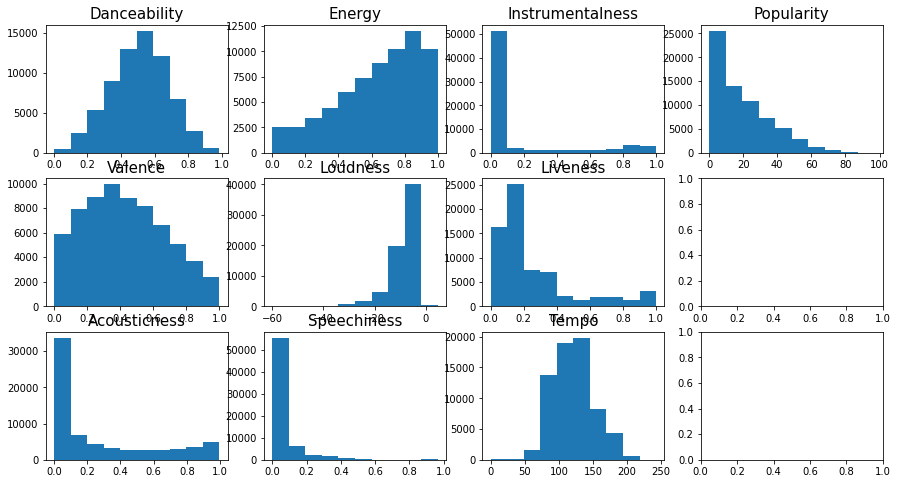

In [487]:
fig,axes = plt.subplots(3, 4,figsize=(15,8))

axes[0,0].hist(df['danceability'])
axes[0,0].set_title('Danceability',fontsize=15)
axes[0,1].hist(df['energy'])
axes[0,1].set_title('Energy',fontsize=15)
axes[0,2].hist(df['instrumentalness'])
axes[0,2].set_title('Instrumentalness',fontsize=15)
axes[1,0].hist(df['valence'])
axes[1,0].set_title('Valence',fontsize=15)
axes[1,1].hist(df['loudness'])
axes[1,1].set_title('Loudness',fontsize=15)
axes[1,2].hist(df['liveness'])
axes[1,2].set_title('Liveness',fontsize=15)
axes[2,0].hist(df['acousticness'])
axes[2,0].set_title('Acousticness',fontsize=15)
axes[2,1].hist(df['speechiness'])
axes[2,1].set_title('Speechiness',fontsize=15)
axes[2,2].hist(df['tempo'])
axes[2,2].set_title('Tempo',fontsize=15)
axes[0,3].hist(df['popularity'])
axes[0,3].set_title('Popularity',fontsize=15)
plt.show()

**Drop popularity and track_number, adds noise**

In [488]:
df.drop(columns=['popularity', 'track_number'], inplace=True)

In [489]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

**Remove outliers only for primary features - removing outliers did not positively impact performance. I left them in for the final model**

In [490]:
df = remove_outlier(df, 'danceability')
df = remove_outlier(df, 'tempo')
df = remove_outlier(df, 'valence')
df = remove_outlier(df, 'energy')

In [491]:
df.shape

(67143, 12)

**Set up model using all features, then only normally distributed**

In [492]:
df.columns

Index(['album', 'name', 'uri', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')

In [493]:
features = df.columns[6:] # all features, used as comparison
features = ['tempo', 'valence', 'danceability', 'energy'] #<-- ended up using just these four features

In [494]:
#scale data
X = MinMaxScaler().fit_transform(df[features])

**Determine optimal number of clusters (mostly for exploration; I'm pretty set on using four clusters per my original problem statement). This cell takes ~20 minutes to run. Leaving this code for future use.**

For n_clusters = 2 The average silhouette_score is : 0.3024894069729329
For n_clusters = 3 The average silhouette_score is : 0.2645163477296091
For n_clusters = 4 The average silhouette_score is : 0.24357211862657047
For n_clusters = 5 The average silhouette_score is : 0.23053730917947374
For n_clusters = 6 The average silhouette_score is : 0.22121701327994864


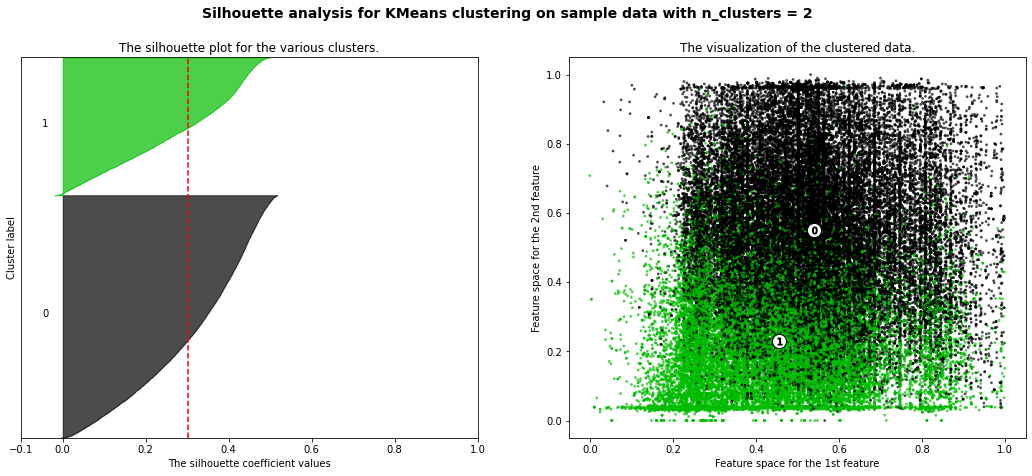

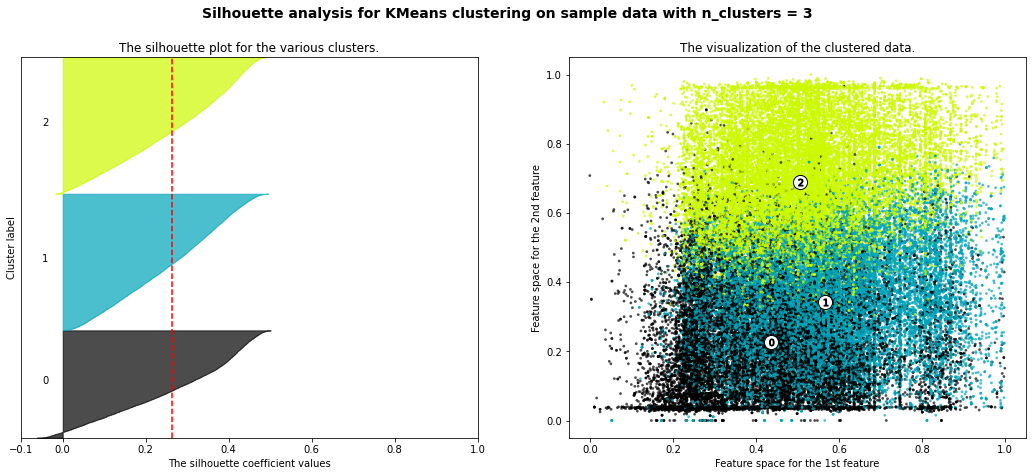

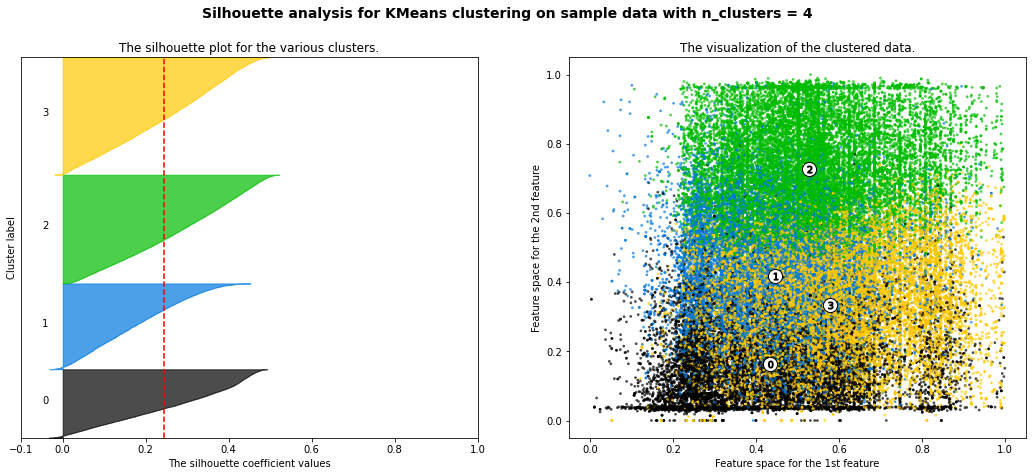

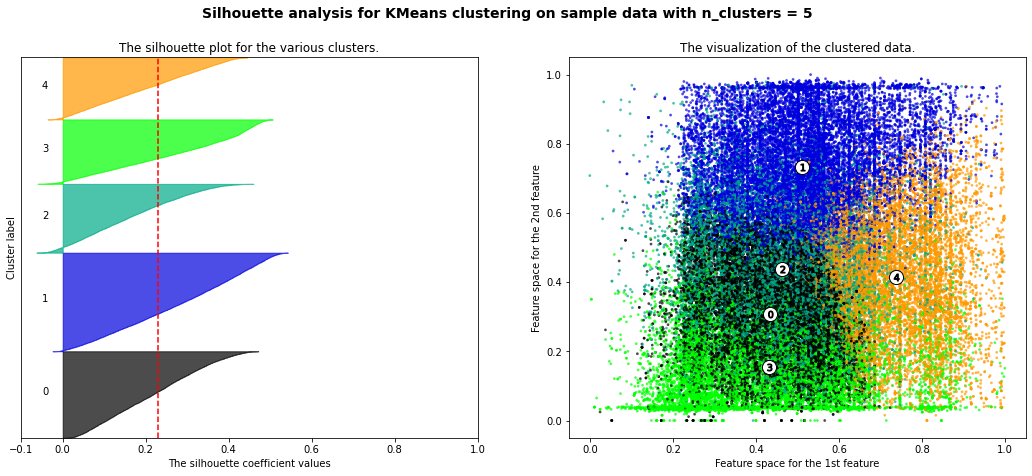

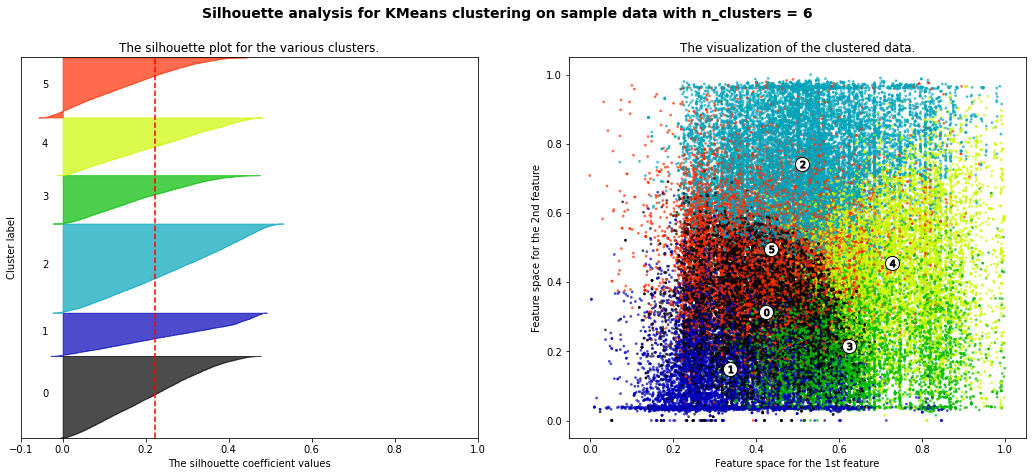

In [495]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

[source](https://www.geeksforgeeks.org/ml-k-means-algorithm/)

**Improve initialization of centroids with kmeans++ to see if it improves model (it does)**

In [496]:
kmeans = KMeans(init="k-means++",n_clusters=4,random_state=42).fit(X)

In [497]:
df['kmeans'] = kmeans.labels_

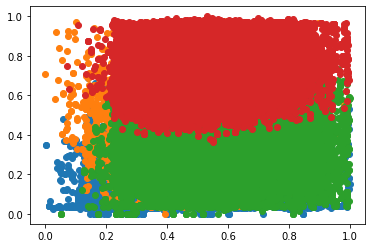

In [498]:
# k-means model
model = KMeans(n_clusters=4)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
# create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

In [499]:
labels = model.labels_
centroids = model.cluster_centers_

print("Predicted clusters to points: ", labels)
print("Location of centroids: ")
print(centroids)

Predicted clusters to points:  [1 3 3 ... 3 1 1]
Location of centroids: 
[[0.43509584 0.16186045 0.3238897  0.27327246]
 [0.44640547 0.41774941 0.6088036  0.50143217]
 [0.57779364 0.33323555 0.38927702 0.82012762]
 [0.52902413 0.72554442 0.60754213 0.77644927]]


In [500]:
#add labels to dataframe for plotting
df['labels'] = labels
df.head()

,album,name,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,kmeans,labels
0,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,Good Day,spotify:track:3uwYgNxFDfx1GoLB6tLoUn,0.110000,0.684,0.677,0.009750,0.3400,-7.355,0.0401,142.048,0.370,1,1
1,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,Choker,spotify:track:732E6ibFkQR5lNIPEeiEnx,0.306000,0.700,0.664,0.000019,0.2490,-8.211,0.0394,142.009,0.585,3,3
2,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,Shy Away,spotify:track:2nG54Y4a3sH9YpfxMolOyi,0.000818,0.588,0.856,0.073900,0.2380,-5.242,0.0316,96.966,0.635,3,3
3,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,The Outside,spotify:track:0yzj6eBs5a6X6d3P5qaQ5J,0.050500,0.785,0.623,0.125000,0.0539,-6.923,0.0403,100.991,0.711,3,3
4,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,Saturday,spotify:track:60dwJ8dnqZ4WrIdiu7LkNR,0.003960,0.687,0.890,0.000939,0.0436,-5.990,0.0344,113.060,0.854,3,3


In [501]:
df['labels'].value_counts()

2    20753
3    19192
1    15127
0    12071
Name: labels, dtype: int64

**Plot and score model**

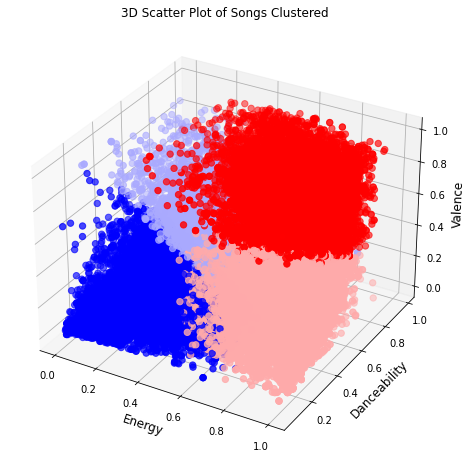

In [502]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

x = df['energy']
y = df['danceability']
z = df['valence']
cmhot = cmhot = plt.get_cmap('bwr')

ax.scatter(x,y,z,c=df['labels'],s=40,cmap=cmhot)
ax.set_xlabel('Energy',fontsize=12)
ax.set_ylabel('Danceability',fontsize=12)
ax.set_zlabel('Valence',fontsize=12)
ax.set_title("3D Scatter Plot of Songs Clustered");

In [503]:
score = silhouette_score(X, labels, metric='euclidean')
score

0.24364058837449476

**Analyze five number summary of songs in each cluster to assign moods**

In [504]:
#split into separate dataframes
zero = df[df['labels'] == 0]
one = df[df['labels'] == 1]
two = df[df['labels'] == 2]
three = df[df['labels'] == 3]

In [505]:
zero.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,kmeans,labels
count,12071.000000,12071.000000,12071.000000,12071.000000,12071.000000,12071.000000,12071.000000,12071.000000,12071.000000,12071.0,12071.0
mean,0.649917,0.356772,0.272877,0.330029,0.214912,-15.210559,0.051092,109.038816,0.161575,0.0,0.0
std,0.325420,0.139014,0.164653,0.396003,0.223003,7.086578,0.083085,31.062218,0.111943,0.0,0.0
min,0.000001,0.057000,0.000020,0.000000,0.024100,-44.696000,0.023000,38.615000,0.000000,0.0,0.0
25%,0.406000,0.251000,0.134000,0.000115,0.098900,-18.864000,0.032000,82.264000,0.068600,0.0,0.0
50%,0.771000,0.358000,0.274000,0.030800,0.115000,-13.261000,0.037100,106.018000,0.142000,0.0,0.0
75%,0.926000,0.457000,0.404000,0.819000,0.207000,-10.054500,0.044700,131.000500,0.225000,0.0,0.0
max,0.996000,0.805000,0.746000,0.998000,0.995000,-0.099000,0.960000,201.252000,0.881000,0.0,0.0


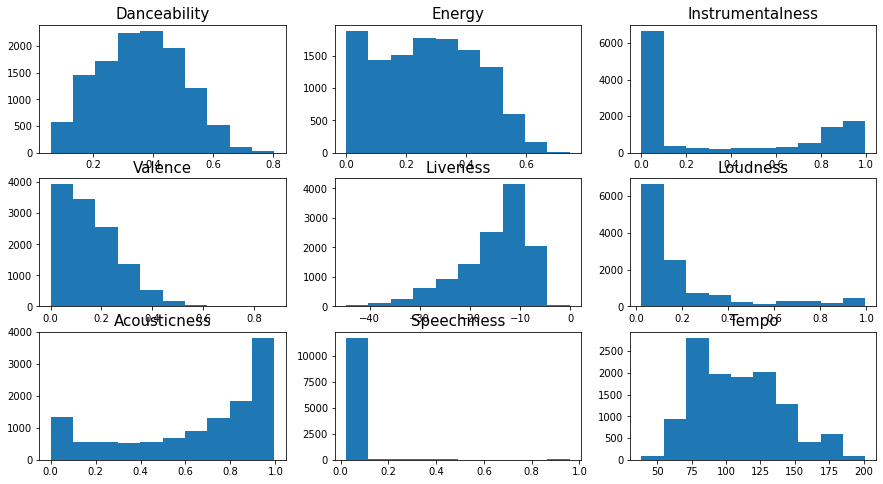

In [506]:
fig,axes = plt.subplots(3, 3,figsize=(15,8))

axes[0,0].hist(zero['danceability'])
axes[0,0].set_title('Danceability',fontsize=15)
axes[0,1].hist(zero['energy'])
axes[0,1].set_title('Energy',fontsize=15)
axes[0,2].hist(zero['instrumentalness'])
axes[0,2].set_title('Instrumentalness',fontsize=15)
axes[1,0].hist(zero['valence'])
axes[1,0].set_title('Valence',fontsize=15)
axes[1,1].hist(zero['loudness'])
axes[1,1].set_title('Liveness',fontsize=15)
axes[1,2].hist(zero['liveness'])
axes[1,2].set_title('Loudness',fontsize=15)
axes[2,0].hist(zero['acousticness'])
axes[2,0].set_title('Acousticness',fontsize=15)
axes[2,1].hist(zero['speechiness'])
axes[2,1].set_title('Speechiness',fontsize=15)
axes[2,2].hist(zero['tempo'])
axes[2,2].set_title('Tempo',fontsize=15)
plt.show()

In [507]:
one.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,kmeans,labels
count,15127.000000,15127.000000,15127.000000,15127.000000,15127.000000,15127.000000,15127.000000,15127.000000,15127.000000,15127.0,15127.0
mean,0.358866,0.620846,0.501467,0.106692,0.210463,-9.705938,0.106436,110.847196,0.416795,1.0,1.0
std,0.311105,0.120887,0.152103,0.250257,0.199118,4.201690,0.176239,23.910083,0.158745,0.0,0.0
min,0.000003,0.180000,0.000416,0.000000,0.018900,-39.814000,0.021900,37.981000,0.000000,1.0,1.0
25%,0.067500,0.537000,0.408000,0.000000,0.099000,-11.450000,0.030600,92.270500,0.308000,1.0,1.0
50%,0.276000,0.616000,0.518000,0.000101,0.125000,-8.696000,0.039600,110.094000,0.411000,1.0,1.0
75%,0.633000,0.703000,0.612000,0.018300,0.237000,-6.869000,0.077150,126.992500,0.520000,1.0,1.0
max,0.996000,0.979000,0.919000,0.993000,0.998000,-0.291000,0.966000,200.074000,0.975000,1.0,1.0


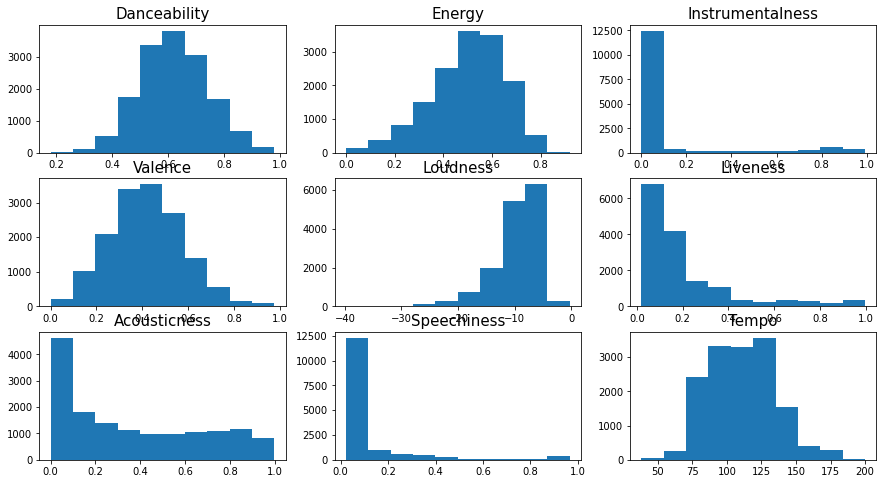

In [508]:
fig,axes = plt.subplots(3, 3,figsize=(15,8))

axes[0,0].hist(one['danceability'])
axes[0,0].set_title('Danceability',fontsize=15)
axes[0,1].hist(one['energy'])
axes[0,1].set_title('Energy',fontsize=15)
axes[0,2].hist(one['instrumentalness'])
axes[0,2].set_title('Instrumentalness',fontsize=15)
axes[1,0].hist(one['valence'])
axes[1,0].set_title('Valence',fontsize=15)
axes[1,1].hist(one['loudness'])
axes[1,1].set_title('Loudness',fontsize=15)
axes[1,2].hist(one['liveness'])
axes[1,2].set_title('Liveness',fontsize=15)
axes[2,0].hist(one['acousticness'])
axes[2,0].set_title('Acousticness',fontsize=15)
axes[2,1].hist(one['speechiness'])
axes[2,1].set_title('Speechiness',fontsize=15)
axes[2,2].hist(one['tempo'])
axes[2,2].set_title('Tempo',fontsize=15)
plt.show()

In [509]:
two.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,kmeans,labels
count,20753.000000,20753.000000,20753.000000,20753.000000,20753.000000,20753.000000,20753.000000,20753.000000,20753.000000,20753.0,20753.0
mean,0.092068,0.417771,0.820317,0.127120,0.332842,-6.127665,0.080781,132.359018,0.333406,2.0,2.0
std,0.174366,0.123660,0.119358,0.259650,0.286647,2.687118,0.079850,28.472784,0.141946,0.0,0.0
min,0.000000,0.061600,0.409000,0.000000,0.018600,-29.139000,0.023000,46.617000,0.000000,2.0,2.0
25%,0.001030,0.331000,0.736000,0.000003,0.112000,-7.354000,0.038800,112.020000,0.226000,2.0,2.0
50%,0.011600,0.423000,0.838000,0.000525,0.212000,-5.717000,0.053900,131.675000,0.339000,2.0,2.0
75%,0.089200,0.506000,0.921000,0.060700,0.432000,-4.403000,0.088100,152.029000,0.439000,2.0,2.0
max,0.989000,0.891000,1.000000,0.992000,1.000000,4.699000,0.951000,201.274000,0.799000,2.0,2.0


In [510]:
three.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,kmeans,labels
count,19192.000000,19192.000000,19192.000000,19192.000000,19192.000000,19192.000000,19192.000000,19192.000000,19192.000000,19192.0,19192.0
mean,0.149007,0.620285,0.776224,0.098519,0.234433,-6.671802,0.082818,124.363233,0.725531,3.0,3.0
std,0.207008,0.127628,0.132547,0.234052,0.210730,2.896610,0.095413,25.542330,0.131176,0.0,0.0
min,0.000002,0.174000,0.187000,0.000000,0.014800,-27.592000,0.022200,49.778000,0.366000,3.0,3.0
25%,0.007258,0.537000,0.695000,0.000000,0.094300,-7.978250,0.035200,105.935000,0.622000,3.0,3.0
50%,0.053500,0.619000,0.799000,0.000113,0.148000,-6.056000,0.046800,123.099500,0.719000,3.0,3.0
75%,0.209000,0.705000,0.877000,0.018500,0.311000,-4.701750,0.077600,140.044000,0.828000,3.0,3.0
max,0.996000,0.984000,0.999000,0.992000,1.000000,2.057000,0.956000,200.884000,1.000000,3.0,3.0


In [511]:
four.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,kmeans,labels
count,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.0
mean,0.418331,0.633757,0.448427,0.113676,0.202530,-10.580456,0.114389,113.716189,0.438784,0.996372,4.0
std,0.320392,0.120629,0.144054,0.259513,0.190724,4.548447,0.190868,23.930675,0.162711,0.283681,0.0
min,0.000009,0.180000,0.000212,0.000000,0.018900,-39.814000,0.021900,37.981000,0.000000,0.000000,4.0
25%,0.106000,0.549000,0.359000,0.000000,0.098600,-12.563000,0.030800,95.553500,0.326000,1.000000,4.0
50%,0.379000,0.631000,0.470000,0.000105,0.122000,-9.493000,0.040300,114.870000,0.430000,1.000000,4.0
75%,0.721500,0.716000,0.553000,0.020700,0.219000,-7.439500,0.080750,129.987500,0.544000,1.000000,4.0
max,0.996000,0.979000,0.796000,0.991000,0.993000,-0.344000,0.966000,200.241000,0.979000,3.000000,4.0


**Look at median values for top features to determine best mood**

In [512]:
#danceability
zero.danceability.median(), one.danceability.median(), two.danceability.median(), three.danceability.median()

(0.358, 0.616, 0.423, 0.619)

In [513]:
#energy
zero.energy.median(), one.energy.median(), two.energy.median(), three.energy.median()

(0.274, 0.518, 0.838, 0.799)

In [514]:
#tempo
zero.tempo.median(), one.tempo.median(), two.tempo.median(), three.tempo.median()

(106.018, 110.094, 131.675, 123.0995)

In [515]:
#valence
zero.valence.median(), one.valence.median(), two.valence.median(), three.valence.median()

(0.142, 0.411, 0.339, 0.719)

In [516]:
#replace numeric labels with mood
df['labels'] = df['labels'].map({0: 'sad',
                  1: 'calm',
                  2: 'energetic',
                  3: 'happy'})

In [517]:
df.head()

,album,name,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,kmeans,labels
0,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,Good Day,spotify:track:3uwYgNxFDfx1GoLB6tLoUn,0.110000,0.684,0.677,0.009750,0.3400,-7.355,0.0401,142.048,0.370,1,calm
1,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,Choker,spotify:track:732E6ibFkQR5lNIPEeiEnx,0.306000,0.700,0.664,0.000019,0.2490,-8.211,0.0394,142.009,0.585,3,happy
2,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,Shy Away,spotify:track:2nG54Y4a3sH9YpfxMolOyi,0.000818,0.588,0.856,0.073900,0.2380,-5.242,0.0316,96.966,0.635,3,happy
3,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,The Outside,spotify:track:0yzj6eBs5a6X6d3P5qaQ5J,0.050500,0.785,0.623,0.125000,0.0539,-6.923,0.0403,100.991,0.711,3,happy
4,spotify:album:0Q5XBpCYFgUWiG9DUWyAmJ,Saturday,spotify:track:60dwJ8dnqZ4WrIdiu7LkNR,0.003960,0.687,0.890,0.000939,0.0436,-5.990,0.0344,113.060,0.854,3,happy


In [518]:
df['labels'].value_counts()

energetic    20753
happy        19192
calm         15127
sad          12071
Name: labels, dtype: int64

**Export to final dataframe to use in `playlist_maker` file**

In [519]:
df.to_csv('data/alt_moods_final.csv', index=False)